# Installs & Imports

In [1]:
!pip install -q lifelines scikit-survival glum

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter, WeibullAFTFitter
from lifelines.datasets import load_rossi
from lifelines import statistics as lifelines_stats

import glum
from glum import GeneralizedLinearRegressor

from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, integrated_brier_score, cumulative_dynamic_auc
from sksurv.util import Surv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

# Setting plot styles
sns.set(style="whitegrid")

# Data Loading

In [3]:
# Load the Rossi dataset
df = load_rossi()
df.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


# Data Exploration

In [4]:
# Summary statistics
print("Summary Statistics:")
display(df.describe())

# Check for missing values
print("\nMissing Values:")
display(df.isnull().sum())

Summary Statistics:


,week,arrest,fin,age,race,wexp,mar,paro,prio
count,432.000000,432.000000,432.00000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000
mean,45.854167,0.263889,0.50000,24.597222,0.877315,0.571759,0.122685,0.618056,2.983796
std,12.662293,0.441251,0.50058,6.113375,0.328456,0.495398,0.328456,0.486426,2.896068
min,1.000000,0.000000,0.00000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,0.000000,0.00000,20.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,52.000000,0.000000,0.50000,23.000000,1.000000,1.000000,0.000000,1.000000,2.000000
75%,52.000000,1.000000,1.00000,27.000000,1.000000,1.000000,0.000000,1.000000,4.000000
max,52.000000,1.000000,1.00000,44.000000,1.000000,1.000000,1.000000,1.000000,18.000000



Missing Values:


,0
week,0
arrest,0
fin,0
age,0
race,0
wexp,0
mar,0
paro,0
prio,0


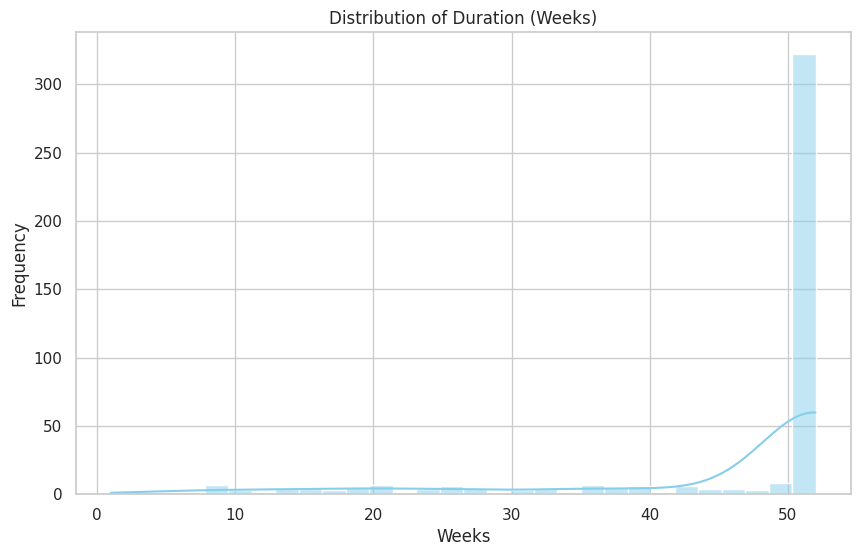

In [5]:
# Distribution of duration (week)
plt.figure(figsize=(10,6))
sns.histplot(df['week'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Duration (Weeks)')
plt.xlabel('Weeks')
plt.ylabel('Frequency')
plt.show()

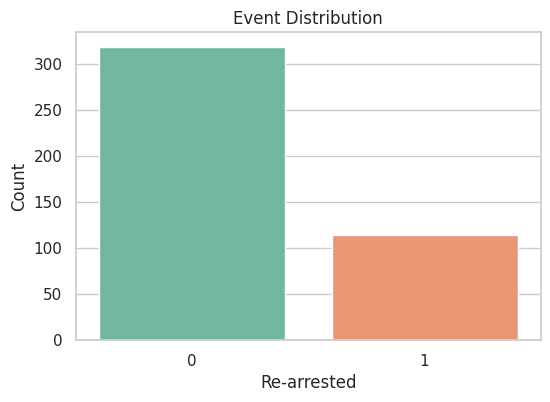

In [6]:
# Event distribution
plt.figure(figsize=(6,4))
sns.countplot(x='arrest', data=df, palette='Set2')
plt.title('Event Distribution')
plt.xlabel('Re-arrested')
plt.ylabel('Count')
plt.show()

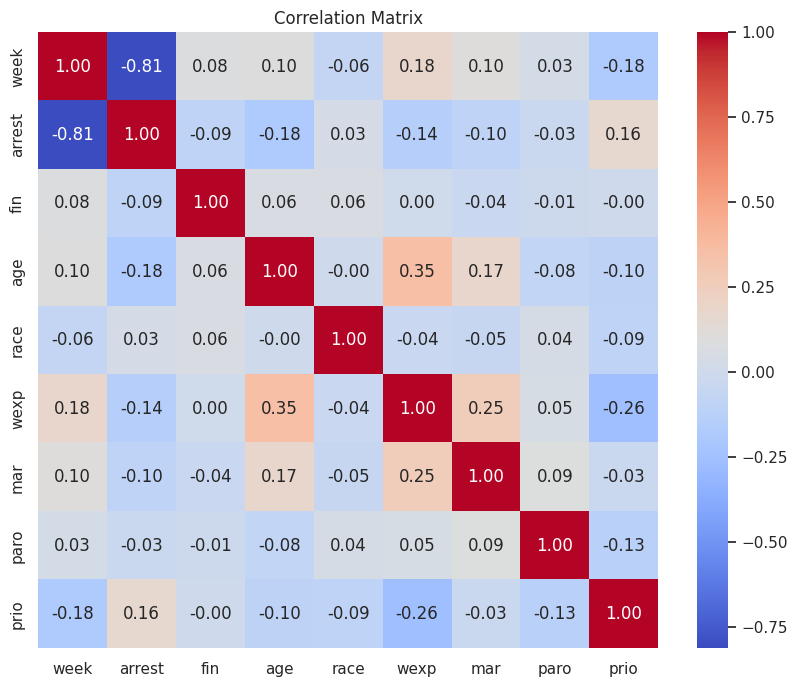

In [7]:
# Correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

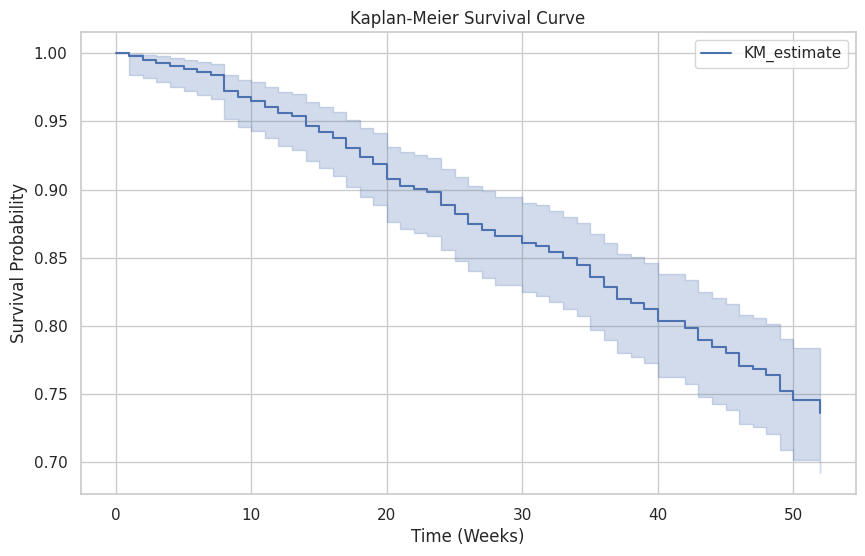

In [8]:
# Kaplan-Meier Estimator for overall survival
kmf = KaplanMeierFitter()
kmf.fit(durations=df['week'], event_observed=df['arrest'])
plt.figure(figsize=(10,6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time (Weeks)')
plt.ylabel('Survival Probability')
plt.show()

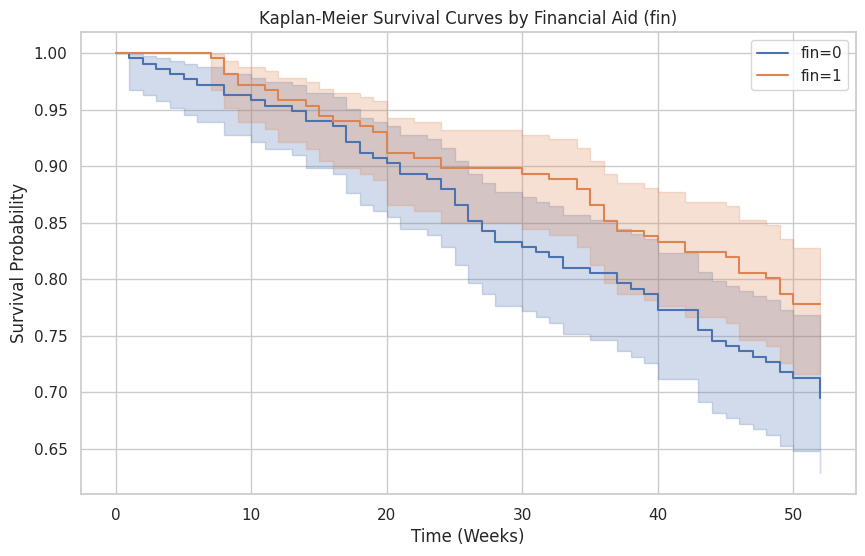

In [9]:
# Survival curves by covariate 'fin'
plt.figure(figsize=(10,6))
for fin_status in df['fin'].unique():
    mask = df['fin'] == fin_status
    kmf.fit(durations=df[mask]['week'], event_observed=df[mask]['arrest'], label=f'fin={fin_status}')
    kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curves by Financial Aid (fin)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

# Data Preparation

In [10]:
# Define features and target
features = ['fin', 'age', 'race', 'wexp', 'mar', 'paro', 'prio']
X = df[features]
y = df[['arrest', 'week']]  # 'arrest' first for Surv.from_dataframe

In [11]:
# Dataset Split for Statistical Models
X_stat = X.copy()
y_stat = y.copy()

X_stat_train, X_stat_test, y_stat_train, y_stat_test = train_test_split(
    X_stat, y_stat, test_size=0.2, random_state=42
)

In [12]:
# Combine X and y
df_stat_train = pd.concat([X_stat_train, y_stat_train], axis=1)
df_stat_test = pd.concat([X_stat_test, y_stat_test], axis=1)

In [13]:
# Dataset Split for Machine Learning Models
X_ml = X.copy()
y_ml = y.copy()

X_ml_train, X_ml_test, y_ml_train, y_ml_test = train_test_split(
    X_ml, y_ml, test_size=0.2, random_state=42
)

In [14]:
# One-hot encode categorical variables for machine learning models
categorical_features = ['race', 'mar']
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_ml_train_encoded = pd.DataFrame(
    encoder.fit_transform(X_ml_train[categorical_features]),
    columns=encoder.get_feature_names_out(categorical_features),
    index=X_ml_train.index
)
X_ml_test_encoded = pd.DataFrame(
    encoder.transform(X_ml_test[categorical_features]),
    columns=encoder.get_feature_names_out(categorical_features),
    index=X_ml_test.index
)

In [15]:
# Isolate numeric features
X_ml_train_numeric = X_ml_train.drop(columns=categorical_features)
X_ml_test_numeric = X_ml_test.drop(columns=categorical_features)

# Standardize numerical features
numerical_features_ml = ['fin', 'age', 'wexp', 'paro', 'prio']
scaler = StandardScaler()
X_ml_train_numeric[numerical_features_ml] = scaler.fit_transform(X_ml_train_numeric[numerical_features_ml])
X_ml_test_numeric[numerical_features_ml] = scaler.transform(X_ml_test_numeric[numerical_features_ml])

In [16]:
# Combine numerical and encoded categorical features
X_ml_train_processed = pd.concat([X_ml_train_numeric, X_ml_train_encoded], axis=1)
X_ml_test_processed = pd.concat([X_ml_test_numeric, X_ml_test_encoded], axis=1)

In [17]:
# Create structured arrays for machine learning models
y_ml_struct_train = Surv.from_dataframe('arrest', 'week', y_ml_train)
y_ml_struct_test = Surv.from_dataframe('arrest', 'week', y_ml_test)

In [18]:
# Display the shapes of the datasets
print("Statistical Models Split:")
print(f"X_stat_train shape: {X_stat_train.shape}")
print(f"X_stat_test shape: {X_stat_test.shape}")

print("\nMachine Learning Models Split:")
print(f"X_ml_train_processed shape: {X_ml_train_processed.shape}")
print(f"X_ml_test_processed shape: {X_ml_test_processed.shape}")

Statistical Models Split:
X_stat_train shape: (345, 7)
X_stat_test shape: (87, 7)

Machine Learning Models Split:
X_ml_train_processed shape: (345, 7)
X_ml_test_processed shape: (87, 7)


# Model Fitting

In [19]:
# Initialize the Cox Proportional Hazards fitter
cph = CoxPHFitter()

# Fit the model with spline terms for 'age' and 'prio'
cph.fit(
    df_stat_train,
    duration_col="week",
    event_col="arrest",
    formula="fin + bs(age, df=4) + race + wexp + mar + paro + bs(prio, df=3)"
)

# Display the summary
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 345 total observations, 257 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 345
number of events observed = 88
   partial log-likelihood = -486.76
         time fit was run = 2024-12-09 08:06:30 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
fin               -0.44      0.65      0.22           -0.87           -0.00                0.42                1.00
bs(age, df=4)[1]  -0.74      0.48      0.72           -2.14            0.67                0.12                1.96
bs(age, df=4)[2]  -1.62      0.20      0.92           -3.42            0.19                0.03                1.21
bs(age, df=4)[3]  -1.18      0.31      1.54           -4.20            1.83                0.02                6.23
bs(age, df=4)[4]  -1.67      0.19      1.17           -3.96            0.62                0.02                1.86
race               0.21      1.23      0.34           -0.46            0.88                0.63                2.41
wexp               0.06      1.06      0.24           -0.41            0.54                0.66                1.72
mar               -0.66      0.52      0.48           -1.60            0.29                0.20                1.33
paro              -0.22      0.80      0.22           -0.65            0.22                0.52                1.25
bs(prio, df=3)[1]  0.79      2.21      1.09           -1.34            2.93                0.26               18.71
bs(prio, df=3)[2]  0.11      1.12      1.12           -2.08            2.31                0.12               10.07
bs(prio, df=3)[3]  2.75     15.67      0.84            1.11            4.39                3.04               80.80

                   cmp to     z      p  -log2(p)
covariate                                       
fin                  0.00 -1.98   0.05      4.37
bs(age, df=4)[1]     0.00 -1.03   0.30      1.71
bs(age, df=4)[2]     0.00 -1.75   0.08      3.65
bs(age, df=4)[3]     0.00 -0.77   0.44      1.18
bs(age, df=4)[4]     0.00 -1.43   0.15      2.71
race                 0.00  0.61   0.54      0.89
wexp                 0.00  0.26   0.80      0.33
mar                  0.00 -1.36   0.17      2.54
paro                 0.00 -0.98   0.33      1.60
bs(prio, df=3)[1]    0.00  0.73   0.47      1.10
bs(prio, df=3)[2]    0.00  0.10   0.92      0.12
bs(prio, df=3)[3]    0.00  3.29 <0.005      9.96
---
Concordance = 0.65
Partial AIC = 997.51
log-likelihood ratio test = 30.60 on 12 df
-log2(p) of ll-ratio test = 8.79

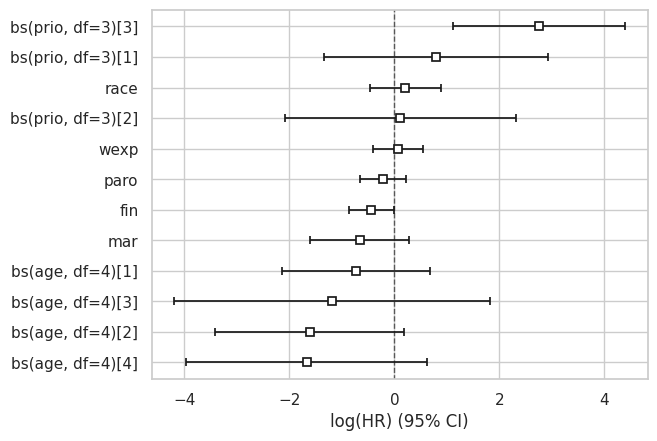

In [20]:
# Plot the coefficients
cph.plot();

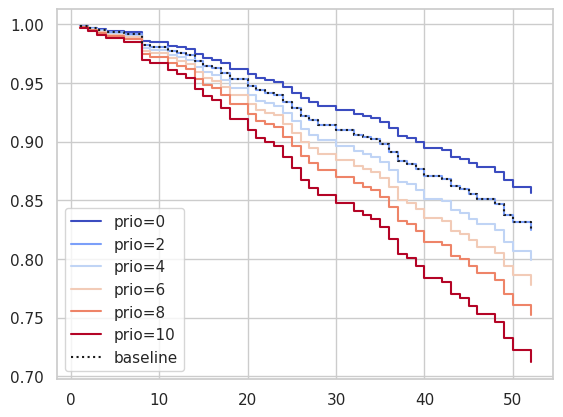

In [21]:
# Plot the effect of a varying covariate
cph.plot_partial_effects_on_outcome(covariates='prio', values=[0, 2, 4, 6, 8, 10], cmap='coolwarm');

In [22]:
# Define the survival_split function
def survival_split(df, time, outcome):
    """Split survival data into one row per observation and period."""
    df_times = df[[time]].drop_duplicates().sort_values(time)
    df["temp"] = 1
    df_times["temp"] = 1
    df_ = pd.merge(df, df_times, on="temp", how="left", suffixes=["_end", ""]).drop(columns="temp")
    df_ = df_.loc[df_[time + "_end"] >= df_[time]].reset_index(drop=True)
    df_[outcome] = np.where(
        df_[time + "_end"] == df_[time],
        df_[outcome],
        0
    )
    return df_.drop(columns=time + "_end")

In [23]:
# Apply survival_split to training and testing data
df_glum_train = survival_split(df_stat_train, "week", "arrest")
df_glum_test = survival_split(df_stat_test, "week", "arrest")

In [24]:
# Initialize and fit the Poisson model
poisson_model = GeneralizedLinearRegressor(
    family="poisson",
    formula="arrest ~ fin + bs(age, df=4) + race + wexp + mar + paro + bs(prio, df=3) + C(week)",
    fit_intercept=False,
).fit(df_glum_train)

In [25]:
# Display coefficient comparison between CoxPH and Poisson models
cox_summary = cph.summary.reset_index()[["covariate", "coef", "se(coef)"]]
poisson_summary = poisson_model.coef_table(X=df_glum_train, robust=False)[["coef", "se"]]
comparison = cox_summary.merge(
    poisson_summary, left_on="covariate", right_index=True, how="inner"
).rename(
    columns={
        "coef_x": "coef_coxph",
        "coef_y": "coef_poisson",
        "se(coef)": "se_coxph",
        "se": "se_poisson",
    }
)

print("Coefficient Comparison between CoxPH and Poisson Models:")
display(comparison)

Coefficient Comparison between CoxPH and Poisson Models:


,covariate,coef_coxph,se_coxph,coef_poisson,se_poisson
0,fin,-0.437578,0.221529,-0.437031,0.230853
1,"bs(age, df=4)[1]",-0.736731,0.718204,-0.731782,0.747931
2,"bs(age, df=4)[2]",-1.616140,0.921551,-1.603054,0.960141
3,"bs(age, df=4)[3]",-1.183452,1.537089,-1.180973,1.601345
4,"bs(age, df=4)[4]",-1.671107,1.168583,-1.660097,1.217365
5,race,0.209338,0.342687,0.210014,0.357109
6,wexp,0.062962,0.243501,0.059879,0.253553
7,mar,-0.656049,0.480933,-0.654454,0.501085
8,paro,-0.217705,0.223088,-0.216816,0.232449
9,"bs(prio, df=3)[1]",0.794765,1.088922,0.785952,1.134491


In [26]:
# Initialize the Weibull AFT fitter
aft = WeibullAFTFitter()

# Fit the model
aft.fit(
    df,
    duration_col="week",
    event_col="arrest",
    formula="fin + age + race + wexp + mar + paro + prio"
)

# Display the summary
aft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
   number of observations = 432
number of events observed = 114
           log-likelihood = -679.92
         time fit was run = 2024-12-09 08:06:35 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                  
lambda_ Intercept  3.99     54.06      0.42            3.17            4.81               23.78              122.92
        fin        0.27      1.31      0.14            0.00            0.54                1.00                1.72
        age        0.04      1.04      0.02            0.01            0.07                1.01                1.07
        race      -0.22      0.80      0.22           -0.66            0.21                0.52                1.23
        wexp       0.11      1.11      0.15           -0.19            0.40                0.83                1.50
        mar        0.31      1.37      0.27           -0.22            0.85                0.80                2.33
        paro       0.06      1.06      0.14           -0.21            0.33                0.81                1.39
        prio      -0.07      0.94      0.02           -0.11           -0.02                0.90                0.98
rho_    Intercept  0.34      1.40      0.09            0.16            0.51                1.18                1.67

                   cmp to     z      p  -log2(p)
param   covariate                               
lambda_ Intercept    0.00  9.52 <0.005     68.98
        fin          0.00  1.97   0.05      4.37
        age          0.00  2.54   0.01      6.51
        race         0.00 -1.02   0.31      1.70
        wexp         0.00  0.70   0.48      1.05
        mar          0.00  1.14   0.25      1.97
        paro         0.00  0.42   0.67      0.57
        prio         0.00 -3.14 <0.005      9.22
rho_    Intercept    0.00  3.81 <0.005     12.81
---
Concordance = 0.64
AIC = 1377.83
log-likelihood ratio test = 33.42 on 7 df
-log2(p) of ll-ratio test = 15.46

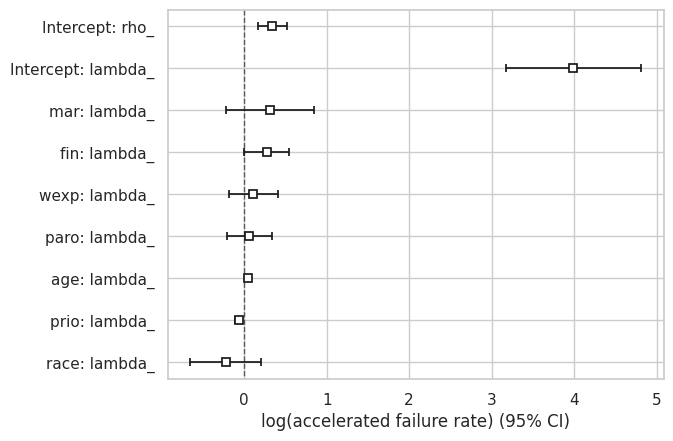

In [27]:
# Plot coefficients
aft.plot();

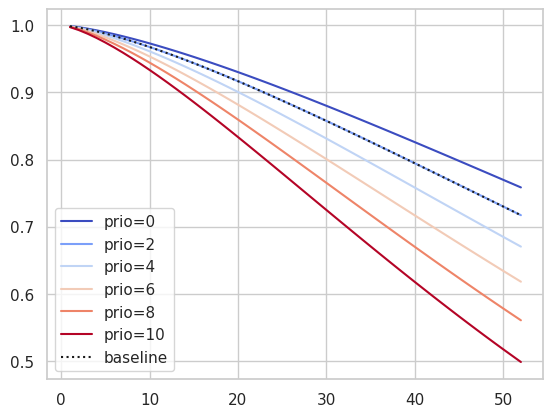

In [28]:
# Plot the effect of a varying covariate
aft.plot_partial_effects_on_outcome(covariates='prio', values=[0, 2, 4, 6, 8, 10], cmap='coolwarm');

In [29]:
# Initialize Random Survival Forest
rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf.fit(X_ml_train_processed, y_ml_struct_train)

RandomSurvivalForest(random_state=42)

In [30]:
# Initialize Gradient Boosting Survival Analysis
gbsa = GradientBoostingSurvivalAnalysis(random_state=42)
gbsa.fit(X_ml_train_processed, y_ml_struct_train)

GradientBoostingSurvivalAnalysis(random_state=42)

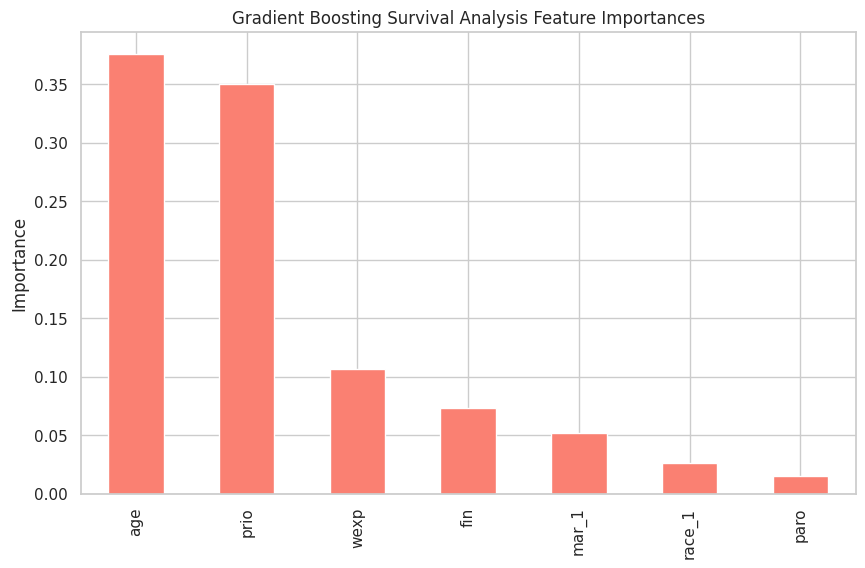

In [31]:
# Display feature importances for GBSA
plt.figure(figsize=(10,6))
feat_importances_gbsa = pd.Series(gbsa.feature_importances_, index=X_ml_train_processed.columns)
feat_importances_gbsa.sort_values(ascending=False).plot.bar(color='salmon')
plt.title('Gradient Boosting Survival Analysis Feature Importances')
plt.ylabel('Importance')
plt.show()

# Model Evaluation

In [32]:
# Define time points for evaluation
time_points = np.linspace(
    y_stat_test["week"].min(), y_stat_test["week"].max(), 100, endpoint=False
)

# Initialize a dictionary to store evaluation metrics
evaluation_results = {}

In [33]:
# Helper function for lifelines models
def get_survival_prob_array_lifelines(model, X, times):
    """Extract survival probabilities for Lifelines models."""
    surv_df = model.predict_survival_function(X, times=times)
    # Transpose the DataFrame to get probabilities in (n_samples, n_times) format
    surv_probs = surv_df.values.T
    return surv_probs

In [34]:
# Cox Proportional Hazards Model
estimate_cox = get_survival_prob_array_lifelines(cph, X_stat_test, times=time_points)
cindex_cox = cph.concordance_index_
ibs_cox = integrated_brier_score(
    Surv.from_dataframe("arrest", "week", y_stat_train),
    Surv.from_dataframe("arrest", "week", y_stat_test),
    estimate_cox,
    time_points
)

evaluation_results["Cox Proportional Hazards"] = {
    "Concordance Index": cindex_cox,
    "Integrated Brier Score": ibs_cox,
}

In [35]:
# Weibull AFT Model
estimate_aft = get_survival_prob_array_lifelines(aft, X_stat_test, times=time_points)
cindex_aft = aft.concordance_index_
ibs_aft = integrated_brier_score(
    Surv.from_dataframe("arrest", "week", y_stat_train),
    Surv.from_dataframe("arrest", "week", y_stat_test),
    estimate_aft,
    time_points
)

evaluation_results["Weibull AFT"] = {
    "Concordance Index": cindex_aft,
    "Integrated Brier Score": ibs_aft,
}

In [36]:
# Helper function for scikit-survival models
def get_survival_prob_array_sksurv(model, X, times):
    """Extract survival probabilities for scikit-survival models."""
    surv_funcs = model.predict_survival_function(X)
    # Interpolate survival probabilities for the specified times
    surv_probs = np.array([func(times) for func in surv_funcs])
    return surv_probs

In [37]:
# Random Survival Forest
estimate_rsf = get_survival_prob_array_sksurv(rsf, X_ml_test_processed, time_points)
cindex_rsf = rsf.score(X_ml_test_processed, y_ml_struct_test)
ibs_rsf = integrated_brier_score(
    y_ml_struct_train,
    y_ml_struct_test,
    estimate_rsf,
    time_points
)

evaluation_results["Random Survival Forest"] = {
    "Concordance Index": cindex_rsf,
    "Integrated Brier Score": ibs_rsf,
}

In [38]:
# Gradient Boosting Survival Analysis
estimate_gbsa = get_survival_prob_array_sksurv(gbsa, X_ml_test_processed, time_points)
cindex_gbsa = gbsa.score(X_ml_test_processed, y_ml_struct_test)
ibs_gbsa = integrated_brier_score(
    y_ml_struct_train,
    y_ml_struct_test,
    estimate_gbsa,
    time_points
)

evaluation_results["Gradient Boosting Survival Analysis"] = {
    "Concordance Index": cindex_gbsa,
    "Integrated Brier Score": ibs_gbsa,
}

In [39]:
# Convert evaluation results to a DataFrame
results = pd.DataFrame(evaluation_results).T
results = results.reset_index().rename(columns={"index": "Model"})
results

,Model,Concordance Index,Integrated Brier Score
0,Cox Proportional Hazards,0.648260,0.112047
1,Weibull AFT,0.640141,0.110030
2,Random Survival Forest,0.670687,0.108491
3,Gradient Boosting Survival Analysis,0.615364,0.115219


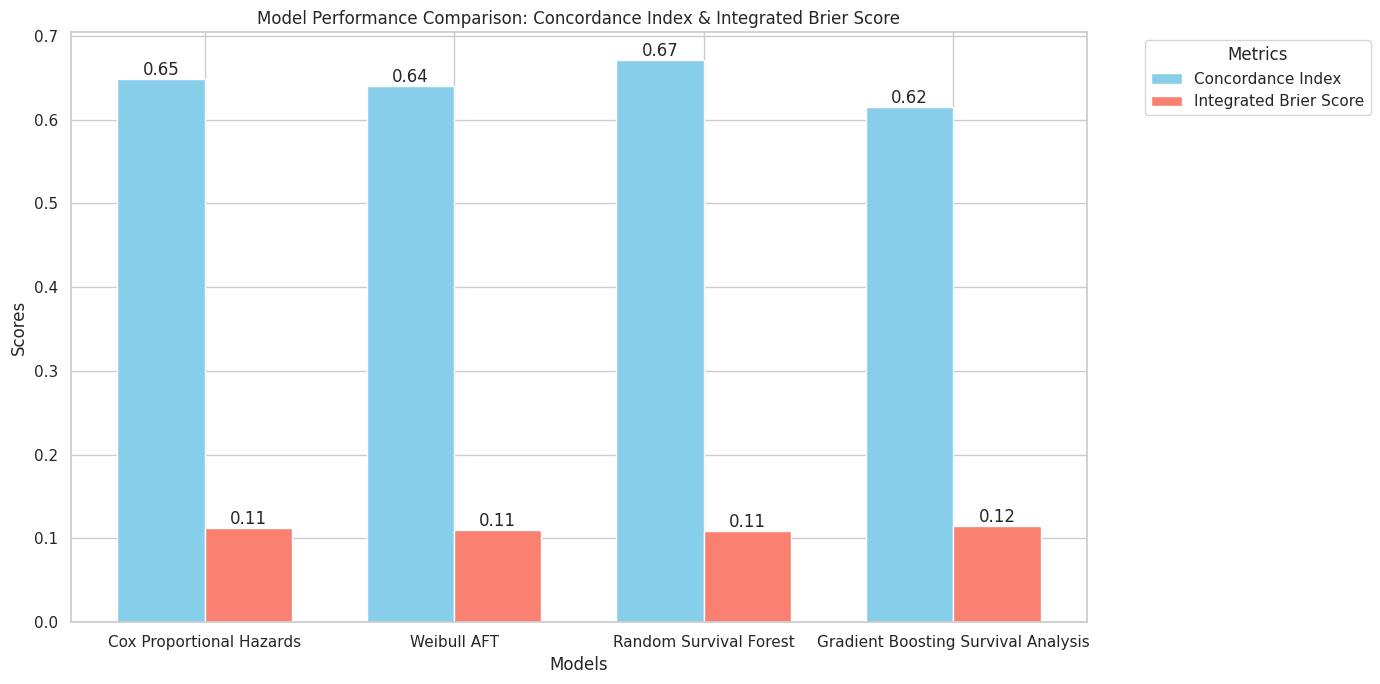

In [40]:
# Bar plot of Concordance Indices and Integrated Brier Scores
plt.figure(figsize=(14, 7))

# Set positions and width for the bars
bar_width = 0.35
positions = np.arange(len(results['Model']))

# Plot Concordance Index
bars_cindex = plt.bar(
    positions, results['Concordance Index'], bar_width, label='Concordance Index', color='skyblue'
)

# Plot Integrated Brier Score
bars_ibs = plt.bar(
    positions + bar_width,
    results['Integrated Brier Score'],
    bar_width,
    label='Integrated Brier Score',
    color='salmon',
)

# Add values on top of the bars
for bar in bars_cindex:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f'{height:.2f}',
        ha='center',
        va='bottom',
    )

for bar in bars_ibs:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f'{height:.2f}',
        ha='center',
        va='bottom',
    )

# Labels and titles
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison: Concordance Index & Integrated Brier Score')
plt.xticks(positions + bar_width / 2, results['Model'], rotation=0)  # Rotate labels to 0

# Adjust legend position to the top-right corner
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title='Metrics')

plt.tight_layout()
plt.show()

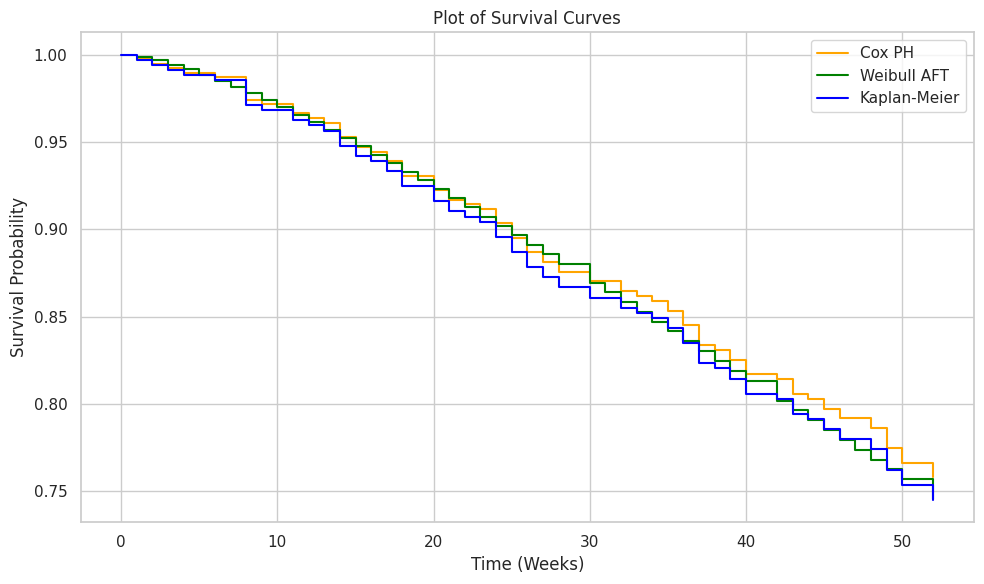

In [41]:
# Plot Survival Function for the Entire Test Set
plt.figure(figsize=(10, 6))

# Predict survival probabilities for all individuals in the test set
cox_surv_df = cph.predict_survival_function(X_stat_test)
aft_surv_df = aft.predict_survival_function(X_stat_test)

# Compute the average survival probability across all individuals in the test set
cox_avg_surv = cox_surv_df.mean(axis=1)
aft_avg_surv = aft_surv_df.mean(axis=1)

# Plot the average survival curve
plt.step(cox_avg_surv.index, cox_avg_surv, where="post", label="Cox PH", color="orange")
plt.step(aft_avg_surv.index, aft_avg_surv, where="post", label="Weibull AFT", color="green")

# Plot Kaplan-Meier survival curve
kmf.fit(df_stat_train['week'], event_observed=df_stat_train['arrest'], label='Kaplan-Meier')
kmf.plot_survival_function(ci_show=False, color='blue')

# Add labels and title
plt.title("Plot of Survival Curves")
plt.xlabel("Time (Weeks)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

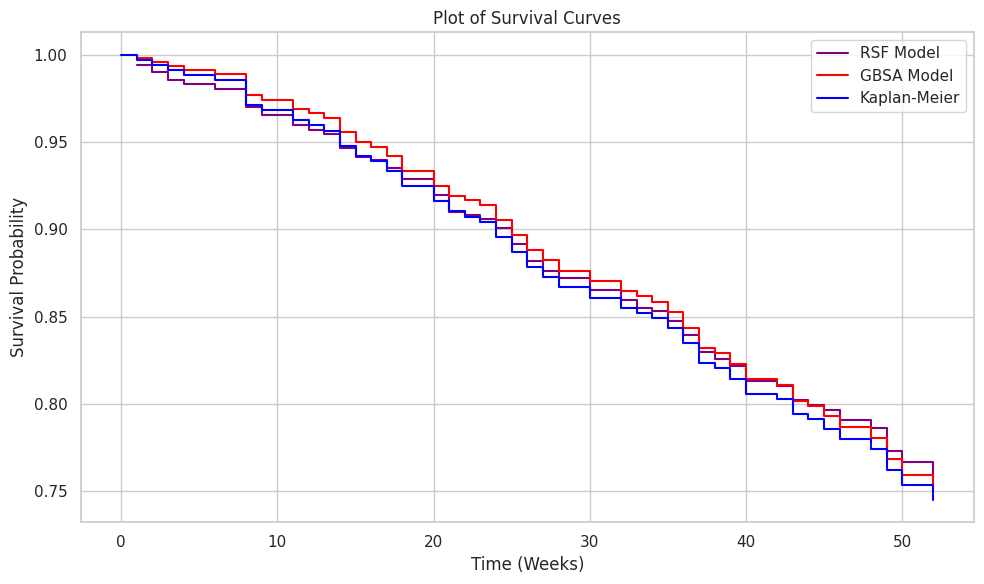

In [42]:
# Plot Survival Function for the Entire Test Set
plt.figure(figsize=(10, 6))

# Random Survival Forest
rsf_surv_funcs = rsf.predict_survival_function(X_ml_test_processed)
rsf_times = rsf_surv_funcs[0].x  # Use the time points from the first survival function
rsf_avg_surv = np.mean([fn(rsf_times) for fn in rsf_surv_funcs], axis=0)

# Gradient Boosting Survival Analysis
gbsa_surv_funcs = gbsa.predict_survival_function(X_ml_test_processed)
gbsa_times = gbsa_surv_funcs[0].x  # Use the time points from the first survival function
gbsa_avg_surv = np.mean([fn(gbsa_times) for fn in gbsa_surv_funcs], axis=0)

# Plot the average survival curve for Random Survival Forest
plt.step(rsf_times, rsf_avg_surv, where="post", label="RSF Model", color="purple")

# Plot the average survival curve for Gradient Boosting Survival Analysis
plt.step(gbsa_times, gbsa_avg_surv, where="post", label="GBSA Model", color="red")

# Plot Kaplan-Meier survival curve
kmf.fit(df_stat_train['week'], event_observed=df_stat_train['arrest'], label='Kaplan-Meier')
kmf.plot_survival_function(ci_show=False, color='blue')

# Add labels and title
plt.title("Plot of Survival Curves")
plt.xlabel("Time (Weeks)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

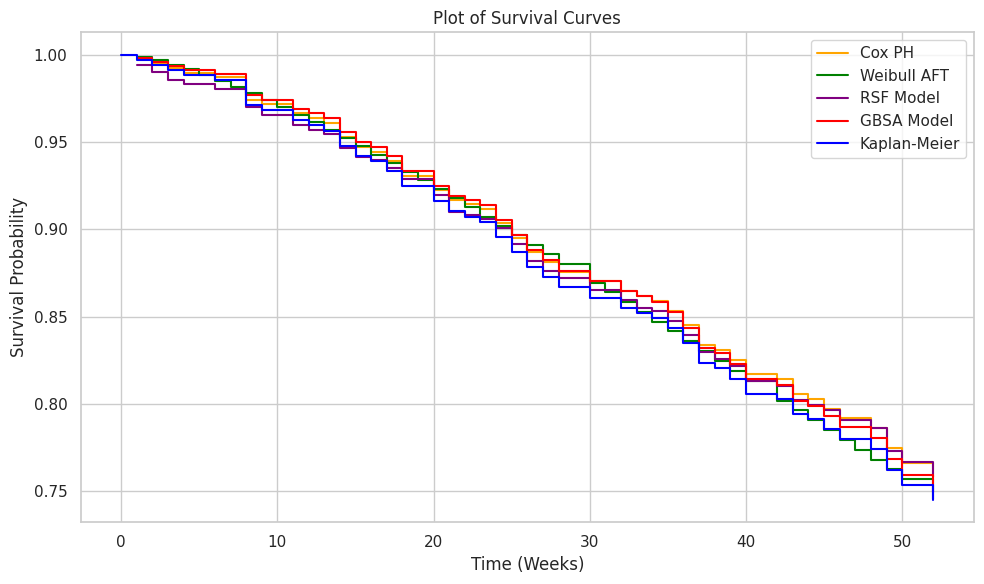

In [43]:
# Plot Survival Function for the Entire Test Set
plt.figure(figsize=(10, 6))

# Predict survival probabilities for all individuals in the test set
cox_surv_df = cph.predict_survival_function(X_stat_test)
aft_surv_df = aft.predict_survival_function(X_stat_test)

# Compute the average survival probability across all individuals in the test set
cox_avg_surv = cox_surv_df.mean(axis=1)
aft_avg_surv = aft_surv_df.mean(axis=1)

# Random Survival Forest
rsf_surv_funcs = rsf.predict_survival_function(X_ml_test_processed)
rsf_times = rsf_surv_funcs[0].x  # Use the time points from the first survival function
rsf_avg_surv = np.mean([fn(rsf_times) for fn in rsf_surv_funcs], axis=0)

# Gradient Boosting Survival Analysis
gbsa_surv_funcs = gbsa.predict_survival_function(X_ml_test_processed)
gbsa_times = gbsa_surv_funcs[0].x  # Use the time points from the first survival function
gbsa_avg_surv = np.mean([fn(gbsa_times) for fn in gbsa_surv_funcs], axis=0)

# Plot the average survival curve for Cox PH
plt.step(cox_avg_surv.index, cox_avg_surv, where="post", label="Cox PH", color="orange")

# Plot the average survival curve for Weibull AFT
plt.step(aft_avg_surv.index, aft_avg_surv, where="post", label="Weibull AFT", color="green")

# Plot the average survival curve for Random Survival Forest
plt.step(rsf_times, rsf_avg_surv, where="post", label="RSF Model", color="purple")

# Plot the average survival curve for Gradient Boosting Survival Analysis
plt.step(gbsa_times, gbsa_avg_surv, where="post", label="GBSA Model", color="red")

# Plot Kaplan-Meier survival curve
kmf.fit(df_stat_train['week'], event_observed=df_stat_train['arrest'], label='Kaplan-Meier')
kmf.plot_survival_function(ci_show=False, color='blue')

# Add labels and title
plt.title("Plot of Survival Curves")
plt.xlabel("Time (Weeks)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()